In [ ]:
! pip install tensorflow==2.12.0


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
raw_data = pd.read_csv('train.csv')
raw_data.set_index('datetime', inplace=True)
raw_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
num = 24*14
train, test = raw_data.iloc[:-num,:], raw_data.iloc[-num:,:]

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled=scaler.fit_transform(train)
test_scaled=scaler.transform(test)

In [ ]:
# construct XY(number of samples + steps of time + number of features)
def createXY(dataset, n_past, target_p=-1):
    '''
    make the data for the lstm
    dataset
    n_past：steps of time
    target_p：
    '''
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i,target_p])
    return np.array(dataX),np.array(dataY)

X_train, Y_train=createXY(train_scaled,30)
X_test, Y_test=createXY(test_scaled,30)
X_train.shape


(10520, 30, 11)

In [ ]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(4, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    grid_model.add(LSTM(4)) #  avoid 3 dimensions
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model=KerasRegressor(build_fn=build_model,verbose=1,validation_data=(X_test,Y_test))

parameters = {'batch_size' : [16,20],
            'epochs' : [8,10],
            'optimizer' : ['adam','Adadelta'] }

grid_search = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)


<ipython-input-8-99fc67080a97>:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model=KerasRegressor(build_fn=build_model,verbose=1,validation_data=(X_test,Y_test))


In [ ]:
grid_search = grid_search.fit(X_train,Y_train)
grid_search.best_params_

Epoch 1/8
329/329 [==============================] - 10s 20ms/step - loss: 0.0494 - val_loss: 0.0268
Epoch 2/8
329/329 [==============================] - 6s 19ms/step - loss: 0.0321 - val_loss: 0.0190
Epoch 3/8
329/329 [==============================] - 6s 18ms/step - loss: 0.0231 - val_loss: 0.0152
Epoch 4/8
329/329 [==============================] - 6s 19ms/step - loss: 0.0189 - val_loss: 0.0127
Epoch 5/8
329/329 [==============================] - 6s 20ms/step - loss: 0.0163 - val_loss: 0.0114
Epoch 6/8
329/329 [==============================] - 6s 19ms/step - loss: 0.0142 - val_loss: 0.0097
Epoch 7/8
329/329 [==============================] - 6s 18ms/step - loss: 0.0134 - val_loss: 0.0092
Epoch 8/8
329/329 [==============================] - 2s 5ms/step - loss: 0.0056
Epoch 1/8
329/329 [==============================] - 10s 22ms/step - loss: 0.0259 - val_loss: 0.0324
Epoch 2/8
329/329 [==============================] - 6s 20ms/step - loss: 0.0149 - val_loss: 0.0252
Epoch 3/8
329/329 

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [ ]:
print(grid_search.best_params_)
model_lstm=grid_search.best_estimator_.model
pre_y=model_lstm.predict(X_test)

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}
10/10 [==============================] - 1s 6ms/step


**evaluation **

In [ ]:
pre_y_repeat = np.repeat(pre_y, X_train.shape[2], axis=-1)
pred=scaler.inverse_transform(np.reshape(pre_y_repeat,(len(pre_y), X_train.shape[2])))[:,-1]


In [ ]:
Y_test_repeat = np.repeat(Y_test, X_train.shape[2], axis=-1)
Y_test_original=scaler.inverse_transform(np.reshape(Y_test_repeat,(len(Y_test),X_train.shape[2])))[:,-1]



In [17]:

from sklearn.metrics import explained_variance_score, mean_absolute_error, \
mean_squared_error, r2_score

import datetime


In [15]:
model_metrics_functions = [explained_variance_score, mean_absolute_error, mean_squared_error,r2_score]
model_metrics_list = [[m(Y_test_original, pred) for m in model_metrics_functions]]
regresstion_score = pd.DataFrame(model_metrics_list, index=['model_xgbr'],
                   columns=['explained_variance', 'mae', 'mse', 'r2'])
regresstion_score


,explained_variance,mae,mse,r2
model_xgbr,0.812303,55.909008,6381.455592,0.779933


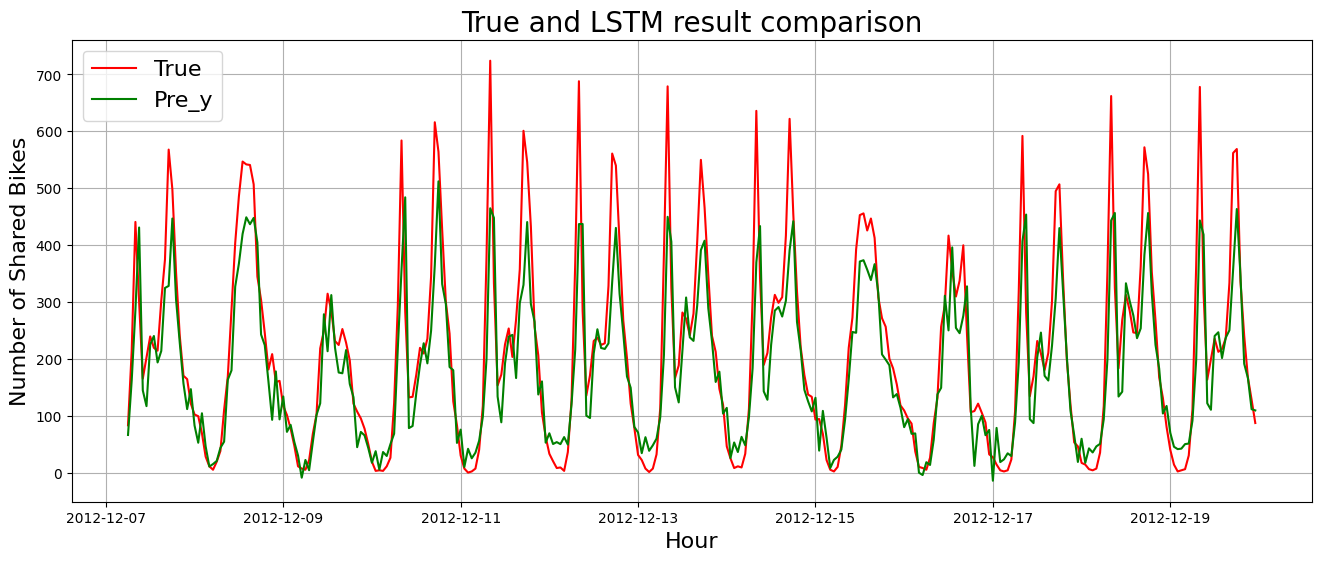

In [18]:
fig = plt.figure(figsize=(16,6))
plt.title('True and LSTM result comparison', fontsize=20)
ds_index = [datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in test.index[30:]]
true_s=pd.Series(Y_test_original, index=ds_index)
plt.plot(true_s, color='red')

pre_s=pd.Series(pred, index=ds_index)
plt.plot(pre_s, color='green')
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Number of Shared Bikes', fontsize=16)
plt.legend(labels=['True', 'Pre_y'], fontsize=16)
plt.grid()
plt.show()
